In [1]:
!pip install numpy pandas matplotlib seaborn sentence-transformers scikit-learn stanza ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict  # Import Dict from the typing module
from IPython.display import display

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

In [3]:
logger = logging.getLogger(__name__)


In [4]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Use Urdu-specific NER model
tokenizer = AutoTokenizer.from_pretrained("mirfan899/urdu-bert-ner")
model = AutoModelForTokenClassification.from_pretrained("mirfan899/urdu-bert-ner")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/709M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

Device set to use cuda:0


In [26]:
import pandas as pd
translated_df  = pd.read_csv("/content/drive/MyDrive/dataset/598_QnAs_translated.csv")
simple_df = pd.read_csv("/content/drive/MyDrive/dataset/simple_rag_qna_results_GPU_version - Copy.csv")
lqr_df = pd.read_csv("/content/drive/MyDrive/dataset/LQR_processed_results - Copy.csv")
modlqr_df = pd.read_csv("/content/drive/MyDrive/dataset/modLQR_processed_results - Copy.csv")

In [27]:
print("QnAs:", len(translated_df ))
print("Simple RAG:", len(simple_df))
print("LQR RAG:", len(lqr_df))
print("modLQR RAG:", len(modlqr_df))

QnAs: 598
Simple RAG: 598
LQR RAG: 598
modLQR RAG: 598


In [28]:
full_df = pd.DataFrame({
    "question": translated_df["translated_question"],
    "context": translated_df["translated_retrieved_sentences"],
    "simple_rag_retrieved_context": simple_df["retrieved_context"],
    "simple_rag_final_answer": simple_df["final_answer"],
    "lqr_rag_retrieved_context": lqr_df["retrieved_context"],
    "lqr_rag_final_answer": lqr_df["final_answer"],
    "modlqr_rag_retrieved_context": modlqr_df["retrieved_context"],
    "modlqr_rag_final_answer": modlqr_df["final_answer"],
    "ground_truth_answer": translated_df["translated_answer"]
})

In [31]:
import numpy as np
class RAGEvaluator:
    def __init__(self, sentence_transformer: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        logger.info("Initializing RAG Evaluator...")
        self.model = SentenceTransformer('intfloat/multilingual-e5-large')

    def compute_cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        return float(cosine_similarity([vec1], [vec2])[0][0])

    def evaluate_faithfulness(self, generated_answer: str, context: str) -> float:
        context_embedding = self.model.encode([context])[0]
        answer_embedding = self.model.encode([generated_answer])[0]
        return self.compute_cosine_similarity(context_embedding, answer_embedding)

    def evaluate_answer_relevancy(self, answer: str, query: str) -> float:
        query_embedding = self.model.encode([query])[0]
        answer_embedding = self.model.encode([answer])[0]
        return self.compute_cosine_similarity(query_embedding, answer_embedding)

    def extract_entities(self, text: str) -> set:
        try:
            ner_results = ner_pipeline(text)
            entities = {ent['word'].strip() for ent in ner_results if ent['score'] > 0.6}
            return entities
        except Exception as e:
            logger.error(f"NER extraction error: {str(e)}")
            return set()

    def evaluate_context_metrics(self, query: str, context: str) -> Dict[str, float]:
        query_entities = self.extract_entities(query)
        context_entities = self.extract_entities(context)

        if not query_entities:
            return {"recall": 0.0, "precision": 0.0}

        intersection = query_entities.intersection(context_entities)
        recall = len(intersection) / len(query_entities)
        precision = len(intersection) / len(context_entities) if context_entities else 0.0

        return {"recall": recall, "precision": precision}

    def evaluate_entity_recall(self, retrieved_context: str, ground_truth_context: str) -> float:
        retrieved_entities = self.extract_entities(retrieved_context)
        truth_entities = self.extract_entities(ground_truth_context)
        return len(retrieved_entities.intersection(truth_entities)) / len(truth_entities) if truth_entities else 0.0

    def evaluate_approach(self, query: str, retrieved_context: str, generated_answer: str, ground_truth_context: str) -> Dict[str, float]:
        try:
            context_metrics = self.evaluate_context_metrics(query, retrieved_context)
            return {
                "faithfulness": self.evaluate_faithfulness(generated_answer, retrieved_context),
                "answer_relevancy": self.evaluate_answer_relevancy(generated_answer, query),
                "context_recall": context_metrics["recall"],
                "context_precision": context_metrics["precision"],
                "entity_recall": self.evaluate_entity_recall(retrieved_context, ground_truth_context)
            }
        except Exception as e:
            logger.error(f"Error evaluating approach: {str(e)}")
            return dict.fromkeys(["faithfulness", "answer_relevancy", "context_recall", "context_precision", "entity_recall"], 0.0)


In [32]:
def evaluate_multiple_rag_approaches(df: pd.DataFrame) -> pd.DataFrame:
    evaluator = RAGEvaluator()
    results = []

    for idx, row in df.iterrows():
        logger.info(f"Evaluating query {idx + 1}/{len(df)}")

        metrics = {}

        for approach in ['simple_rag', 'lqr_rag', 'modlqr_rag']:
            approach_metrics = evaluator.evaluate_approach(
                row["question"],
                row[f"{approach}_retrieved_context"],
                row[f"{approach}_final_answer"],
                row["context"]
            )
            metrics.update({f"{approach}_{k}": v for k, v in approach_metrics.items()})

        results.append({
            "query": row["question"],
            "ground_truth_context": row["context"],
            **metrics
        })

    results_df = pd.DataFrame(results)
    return results_df


In [33]:
def plot_all_metrics(results_df: pd.DataFrame):
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 5 * len(metrics)))
    fig.suptitle('RAG Evaluation Metrics Comparison (3 Approaches)', y=1.02, fontsize=18)

    for ax, metric in zip(axes, metrics):
        data = pd.DataFrame({
            'Simple RAG': results_df[f'simple_rag_{metric}'],
            'LQR RAG': results_df[f'lqr_rag_{metric}'],
            'ModLQR RAG': results_df[f'modlqr_rag_{metric}']
        })
        sns.boxplot(data=data, ax=ax)
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_ylabel('Score')

    plt.tight_layout()
    plt.show()


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

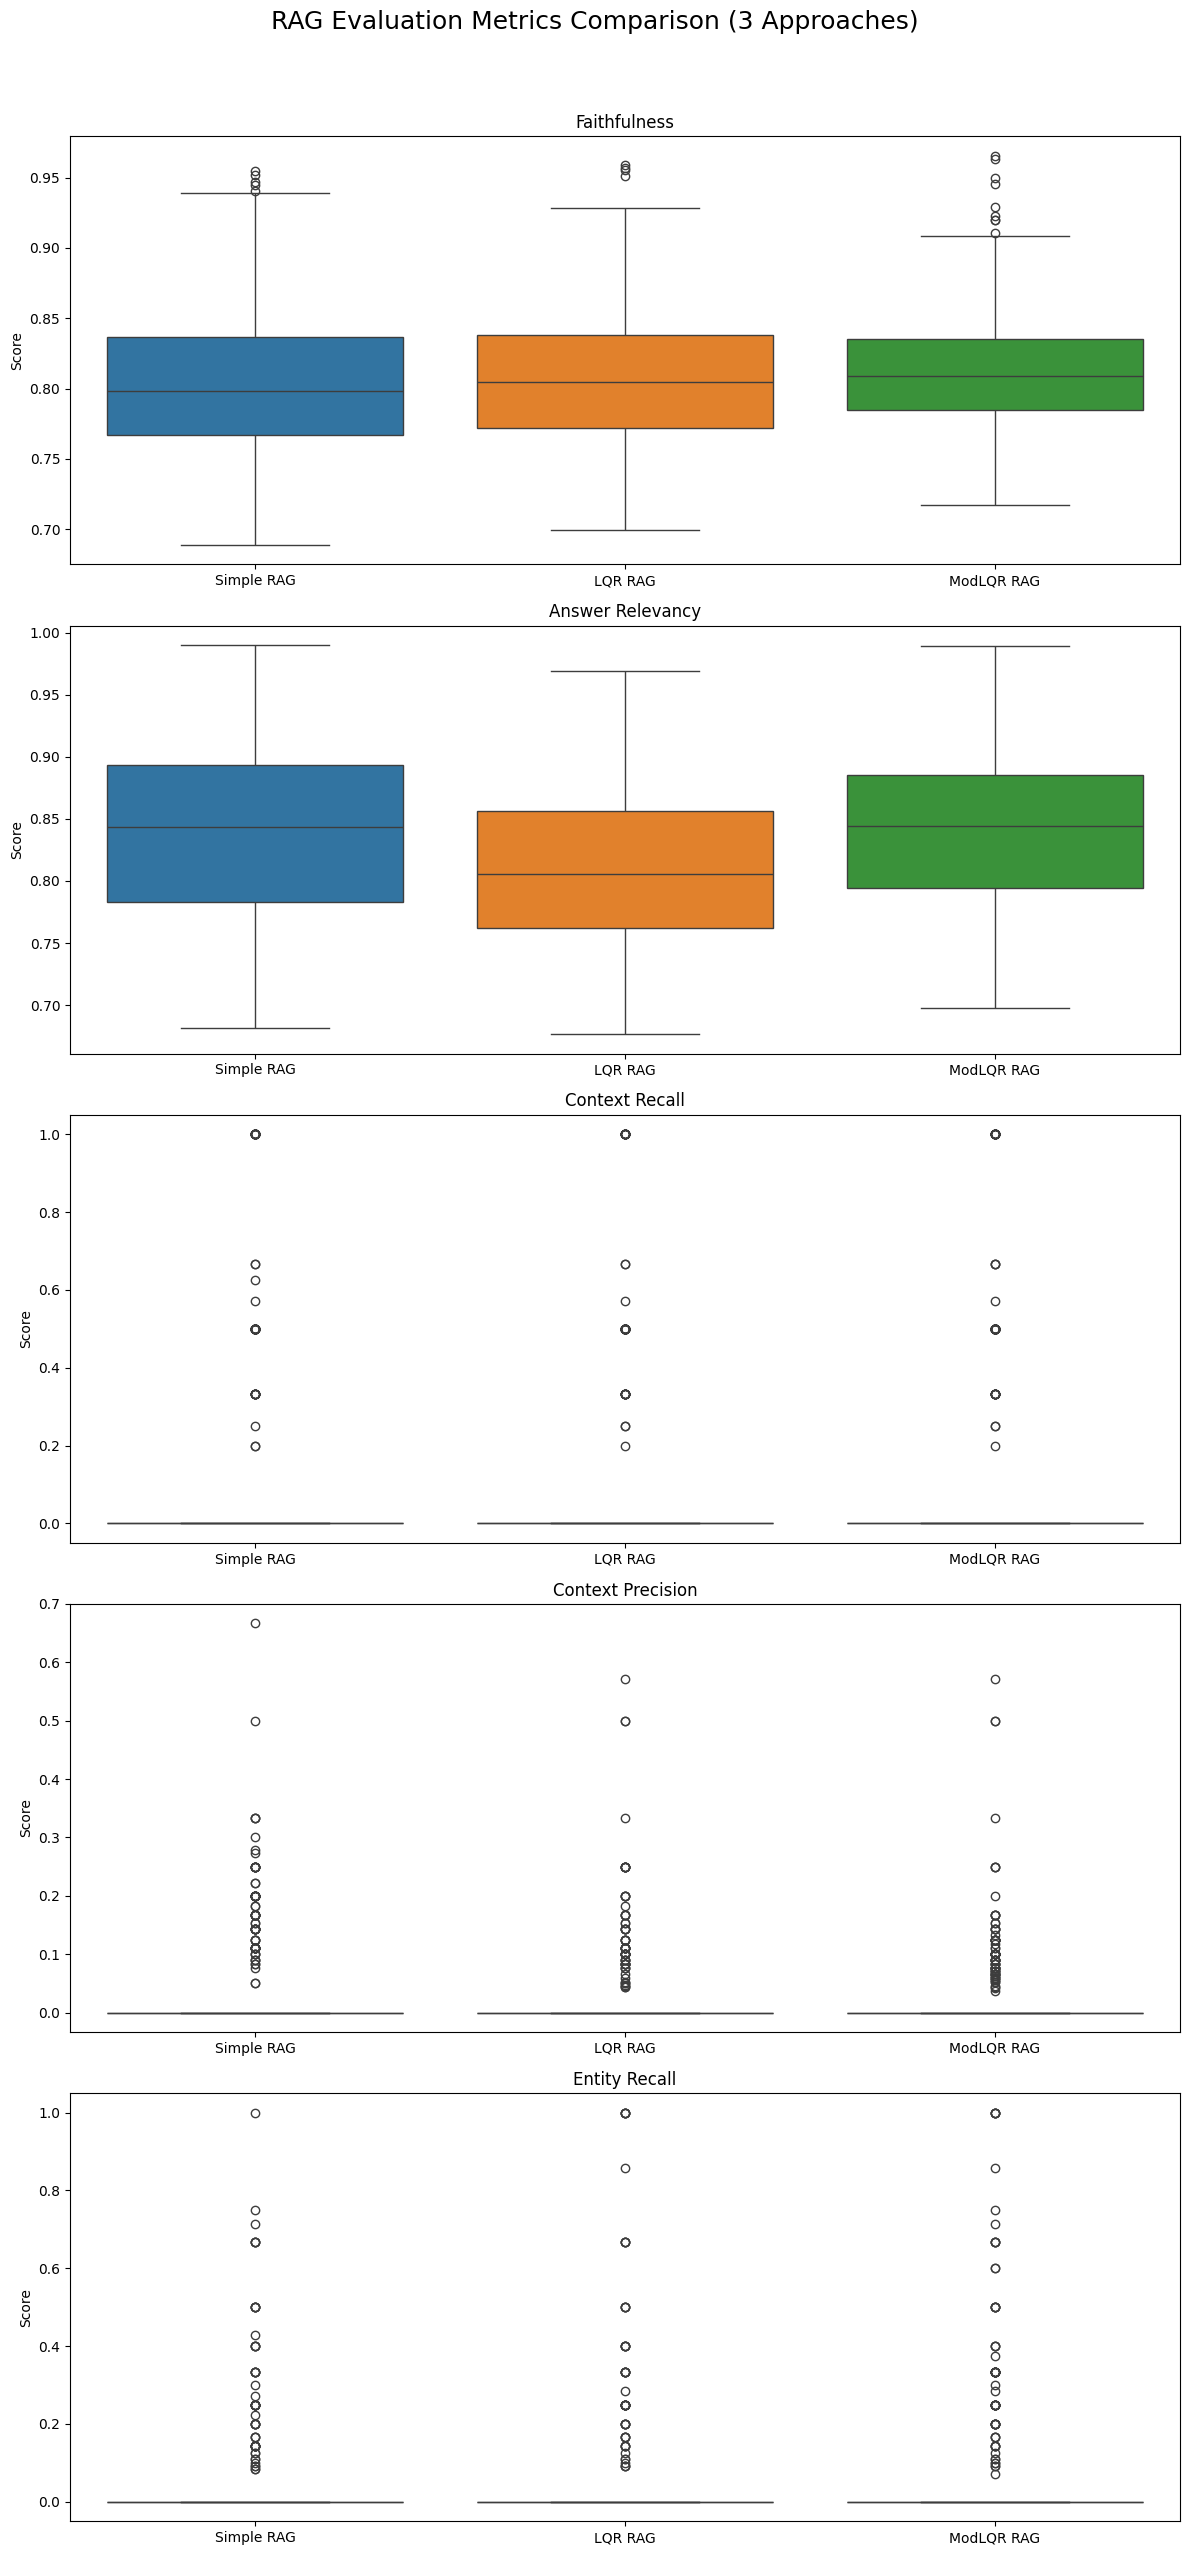

In [34]:
results_df = evaluate_multiple_rag_approaches(full_df)
plot_all_metrics(results_df)

In [35]:
import pandas as pd

def summarize_results(results_df):
    # Define metrics list
    metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'entity_recall']

    summary_data = []

    for metric in metrics:
        summary_data.append({
            'Metric': metric.replace('_', ' ').title(),
            'Simple RAG': results_df[f'simple_rag_{metric}'].mean(),
            'LQR RAG': results_df[f'lqr_rag_{metric}'].mean(),
            'ModLQR RAG': results_df[f'modlqr_rag_{metric}'].mean()
        })

    summary_df = pd.DataFrame(summary_data)
    # Formatting for readability
    summary_df[['Simple RAG', 'LQR RAG', 'ModLQR RAG']] = summary_df[['Simple RAG', 'LQR RAG', 'ModLQR RAG']].round(3)

    print("\nAverage Metrics Summary:")
    display(summary_df)

    return summary_df

# Assuming your results_df columns are like 'simple_rag_faithfulness', 'lqr_rag_faithfulness', etc.
summary_df = summarize_results(results_df)



Average Metrics Summary:


,Metric,Simple RAG,LQR RAG,ModLQR RAG
0,Faithfulness,0.803,0.806,0.811
1,Answer Relevancy,0.839,0.813,0.843
2,Context Recall,0.087,0.071,0.084
3,Context Precision,0.024,0.017,0.017
4,Entity Recall,0.030,0.034,0.043
